# Open exploration
Exploring 1000 scenarios over the whole uncertainty space with lhs. 60 replications are used. This notebook includes the following:

- Fitting a linear regression model
- Feature scoring using the extra trees algorithm
- Visual analysis using plotting
- Scenario discovery using PRIM

In [1]:
from ema_workbench.analysis import prim
from ema_workbench import load_results, save_results, ema_logging
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

<frozen importlib._bootstrap>:914: ImportWarning: ShimImporter.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: ShimImporter.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: ShimImporter.find_spec() not found; falling back to find_module()


In [2]:
# enable EMA logging
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [3]:
# load orginal data
experiments_original, results = load_results('../data/output/EMA/resultsOpenExploration2.tar.gz')

[MainProcess/INFO] results loaded successfully from /home/tevito/Documents/EPA/Year2/thesis/git/CrowdSim/data/output/EMA/resultsOpenExploration2.tar.gz


In [4]:
# convert groupforming column in experiments to readable format
# e.g. [0.5, 0.38, 0.075, 0.03, 0.015] translates to 50% groupForming
groups = {str([[round(0.5 - num/100, 2), round(0.38 + num/100, 2), 0.075, 0.03, 0.015] for i in range(4)]):(50 + num) for num in range(0, 36)}
experiments = experiments_original.copy()
experiments = experiments.astype({'groupForming': str})
experiments = experiments.replace({'groupForming': groups})

In [5]:
experiments.head()

,groupForming,meanFreeFlowSpeed,obstPotentialHeight,pedPotentialHeight,sdFreeFlowSpeed,spawnFrequencyA,spawnFrequencyB,spawnFrequencyC,spawnFrequencyD,scenario,policy,model
0,57,0.876190,8.978933,28.785967,0.198374,4.0,5.0,5.0,1.0,0,None,model
1,55,0.815327,6.604905,27.690323,0.180793,5.0,4.0,4.0,5.0,1,None,model
2,69,0.800696,8.325531,22.223448,0.152924,4.0,5.0,4.0,2.0,2,None,model
3,81,0.903893,5.002556,22.640833,0.171034,1.0,1.0,2.0,5.0,3,None,model
4,77,0.776615,5.718409,14.068544,0.243357,2.0,1.0,1.0,3.0,4,None,model


In [6]:
experiments.describe()

,groupForming,meanFreeFlowSpeed,obstPotentialHeight,pedPotentialHeight,sdFreeFlowSpeed,spawnFrequencyA,spawnFrequencyB,spawnFrequencyC,spawnFrequencyD
count,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,67.49950,0.909998,5.999985,27.500005,0.225000,3.000000,3.000000,3.000000,3.000000
std,10.38985,0.144373,2.309943,12.993516,0.043312,1.414567,1.414567,1.414567,1.414567
min,50.00000,0.660178,2.003379,5.021724,0.150063,1.000000,1.000000,1.000000,1.000000
25%,58.75000,0.785068,3.999384,16.259578,0.187500,2.000000,2.000000,2.000000,2.000000
50%,67.50000,0.909975,5.999808,27.499591,0.224993,3.000000,3.000000,3.000000,3.000000
75%,76.25000,1.034974,7.998291,38.746869,0.262467,4.000000,4.000000,4.000000,4.000000
max,85.00000,1.159758,9.996812,49.980861,0.299926,5.000000,5.000000,5.000000,5.000000


In [7]:
results_df = pd.DataFrame(results)
results_df.head()

,meanSpeed,meanDensityArea1,maxDensityArea1,meanDensityArea2,maxDensityArea2,meanDensityArea3,maxDensityArea3,meanDensityArea4,maxDensityArea4
0,0.547188,0.038164,0.137350,0.034630,0.125828,0.527728,1.473702,0.373789,1.082277
1,0.606996,0.034499,0.140304,0.020759,0.079928,0.261214,0.505868,0.112790,0.262274
2,0.546906,0.032788,0.128489,0.027499,0.105449,0.468890,1.302115,0.287189,0.866216
3,0.670609,0.460849,0.957613,0.117910,0.348599,0.641497,1.342286,0.529189,1.499388
4,0.557421,0.399850,0.851573,0.106407,0.377392,0.871910,2.130785,0.361143,0.980764


In [8]:
results_df.describe()

,meanSpeed,meanDensityArea1,maxDensityArea1,meanDensityArea2,maxDensityArea2,meanDensityArea3,maxDensityArea3,meanDensityArea4,maxDensityArea4
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.636357,0.150511,0.381965,0.059472,0.195607,0.609911,1.419672,0.363399,0.984841
std,0.096925,0.123932,0.242090,0.026140,0.076233,0.279925,0.700987,0.202332,0.575356
min,0.403947,0.024074,0.101019,0.014888,0.058708,0.169288,0.371295,0.082493,0.224355
25%,0.560765,0.061218,0.207060,0.039335,0.136112,0.389994,0.835270,0.199657,0.496109
50%,0.625281,0.108494,0.309851,0.056603,0.185564,0.571677,1.371553,0.325194,0.869376
75%,0.705181,0.167300,0.452961,0.074314,0.245230,0.772606,1.794281,0.482062,1.367164
max,0.938246,0.543619,1.248855,0.166799,0.457694,1.806192,3.945367,1.269828,3.435636


In [9]:
# drop unneeded columns from experiments for the analysis
X = experiments.drop(['model','policy', 'scenario'], inplace=False, axis=1)

## Visual analysis

[MainProcess/INFO] no time dimension found in results


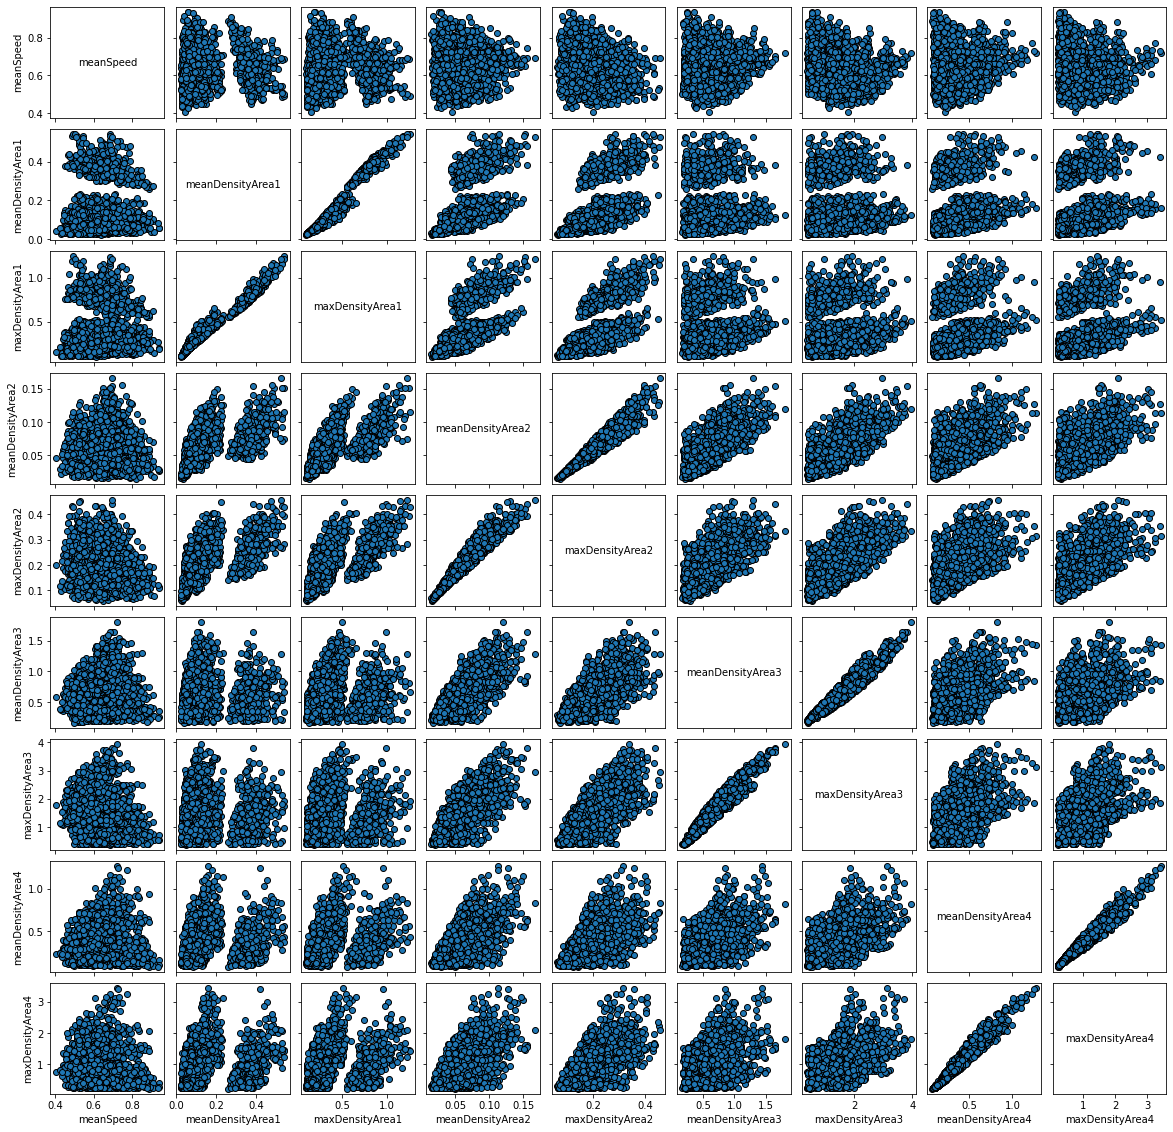

In [10]:
from ema_workbench.analysis import pairs_plotting

fig, axes = pairs_plotting.pairs_scatter(
    experiments,
    results,
)

fig.set_size_inches(20, 20)
plt.show()

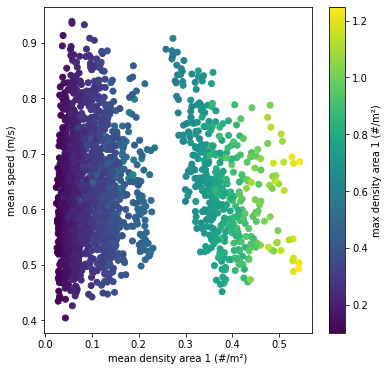

In [11]:
fig, ax = plt.subplots(figsize=(6,6))

sc = ax.scatter(results['meanDensityArea1'], results['meanSpeed'], c=results['maxDensityArea1'])
cbar = plt.colorbar(sc)
cbar.set_label('max density area 1 (#/m²)')
ax.set_xlabel('mean density area 1 (#/m²)')
ax.set_ylabel('mean speed (m/s)')
plt.show()

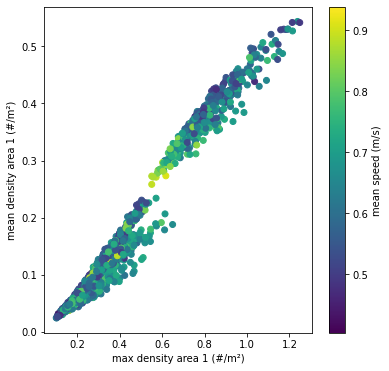

In [12]:
fig, ax = plt.subplots(figsize=(6,6))

sc = ax.scatter(results['maxDensityArea1'], results['meanDensityArea1'], c=results['meanSpeed'])
cbar = plt.colorbar(sc)
cbar.set_label('mean speed (m/s)')
ax.set_xlabel('max density area 1 (#/m²)')
ax.set_ylabel('mean density area 1 (#/m²)')
plt.show()

## Linear regression model

In [13]:
import statsmodels.api as sm

# add constant
X_0 = sm.add_constant(X)

In [14]:
# specify outcome to fit linear regression on
outcome = 'maxDensityArea3'
# outcome = 'meanSpeed'

In [15]:
est = sm.OLS(results_df[outcome], X_0.astype(float)).fit()
print(est.summary())
print(est.params)

                            OLS Regression Results                            
Dep. Variable:        maxDensityArea3   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     2091.
Date:                Mon, 16 May 2022   Prob (F-statistic):               0.00
Time:                        09:53:00   Log-Likelihood:                 220.53
No. Observations:                2000   AIC:                            -421.1
Df Residuals:                    1990   BIC:                            -365.1
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   3.2028    

## Feature scoring

In [16]:
from ema_workbench.analysis import feature_scoring

# use the extra trees algorithm
fs = feature_scoring.get_feature_scores_all(
    x=X,
    y=results,
    alg='extra trees',
)

/home/tevito/anaconda3/envs/CrowdSim/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/tevito/anaconda3/envs/CrowdSim/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
<frozen importlib._bootstrap>:914: ImportWarning: ShimImporter.find_spec() not found; falling back to find_module()
/home/tevito/anaconda3/envs/CrowdSim/lib/python3.10/site-packages/ema_workbench-2.1.3-py3.10.egg/ema_workbench/analysis/feature_scoring.py:389: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  complete = complete.append(fs.T, sort=True)
/home/tevito/anaconda3/envs/CrowdSim/lib/python3.10/site-pack

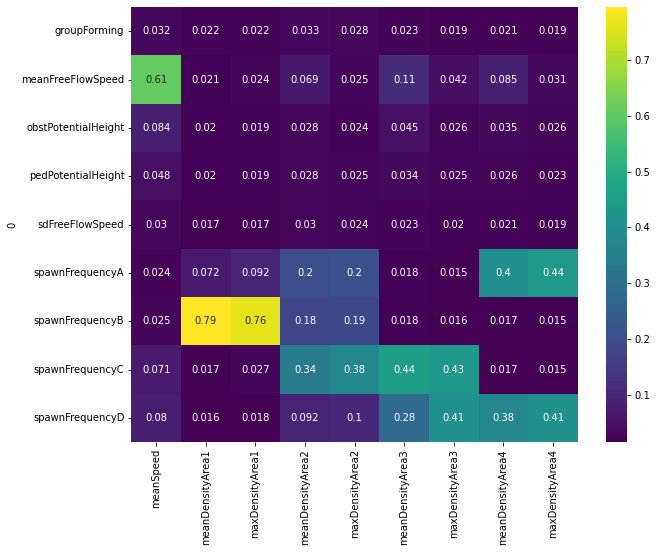

In [17]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(fs,
            cmap="viridis",
            annot=True,
            ax=ax)
plt.show()

In [18]:
# repeat for binary clasification
from ema_workbench.analysis import RuleInductionType

x = experiments
y = (
    (results['maxDensityArea1'] >= 1) |
    (results['maxDensityArea2'] >= 1) |
    (results['maxDensityArea3'] >= 1) |
    (results['maxDensityArea4'] >= 1) 
)

fs, alg = feature_scoring.get_ex_feature_scores(
    x, y, mode=RuleInductionType.CLASSIFICATION
)
fs.sort_values(ascending=False, by=1).round(2)

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


,1
0,
spawnFrequencyD,0.35
spawnFrequencyC,0.34
spawnFrequencyA,0.13
sdFreeFlowSpeed,0.03
pedPotentialHeight,0.03
obstPotentialHeight,0.03
meanFreeFlowSpeed,0.03
groupForming,0.03
spawnFrequencyB,0.02


## PRIM

In [19]:
x = experiments
y = (
    (results['maxDensityArea1'] >= np.percentile(results['maxDensityArea1'], 80)) |
    (results['maxDensityArea2'] >= np.percentile(results['maxDensityArea2'], 80)) 
)
prim_alg = prim.Prim(
    x,
    y,
    threshold=0.8)

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


In [20]:
box1 = prim_alg.find_box()

[MainProcess/INFO] 2000 points remaining, containing 610 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.1215, coverage: 0.3983606557377049, density: 1.0 restricted_dimensions: 4


In [21]:
boxes = [box1]

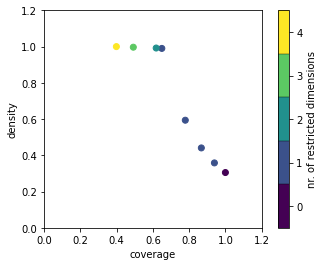

In [22]:
for b in boxes:
    b.show_tradeoff()
    plt.show()

coverage    0.398361
density     1.000000
id          7.000000
mass        0.121500
mean        1.000000
res_dim     4.000000
Name: 7, dtype: float64

                    box 7                                           
                      min       max                        qp values
spawnFrequencyB  1.000000  1.500000  [-1.0, 1.2881052267775426e-111]
spawnFrequencyC  1.000000  4.500000      [-1.0, 0.20640239898287147]
spawnFrequencyA  1.000000  4.500000      [-1.0, 0.44545769712869604]
sdFreeFlowSpeed  0.156076  0.299926                      [1.0, -1.0]



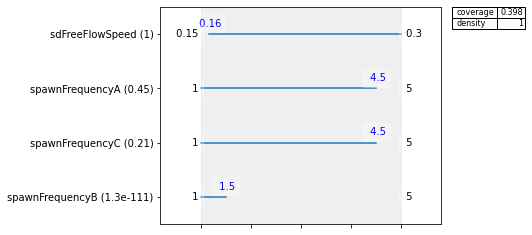

In [23]:
for b in boxes:
    b.inspect()
    b.inspect(style="graph")
    plt.show()

In [24]:
box2 = prim_alg.find_box()

[MainProcess/INFO] 1757 points remaining, containing 367 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.05, coverage: 0.16393442622950818, density: 1.0 restricted_dimensions: 4


In [25]:
x = experiments
y = (
    (results['maxDensityArea1'] >= 1) |
    (results['maxDensityArea2'] >= 1) |
    (results['maxDensityArea3'] >= 1) |
    (results['maxDensityArea4'] >= 1) 
)
prim_alg = prim.Prim(
    x,
    y,
    threshold=0.8)

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


In [26]:
box1 = prim_alg.find_box()

[MainProcess/INFO] 2000 points remaining, containing 1469 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.361, coverage: 0.4914908100748809, density: 1.0 restricted_dimensions: 3


In [27]:
box2 = prim_alg.find_box()

[MainProcess/INFO] 1278 points remaining, containing 747 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.1825, coverage: 0.24846834581347857, density: 1.0 restricted_dimensions: 2


In [28]:
box3 = prim_alg.find_box()

[MainProcess/INFO] 913 points remaining, containing 382 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.0505, coverage: 0.06875425459496257, density: 1.0 restricted_dimensions: 3


In [29]:
box4 = prim_alg.find_box()

[MainProcess/INFO] 812 points remaining, containing 281 cases of interest
[MainProcess/INFO] mean: 0.9924242424242424, mass: 0.066, coverage: 0.08917631041524847, density: 0.9924242424242424 restricted_dimensions: 2


In [30]:
box5 = prim_alg.find_box()

[MainProcess/INFO] 680 points remaining, containing 150 cases of interest
[MainProcess/INFO] box does not meet threshold criteria, value is 0.43529411764705883, returning dump box


In [31]:
boxes = [box1, box2, box3, box4]

In [32]:
prim_alg.boxes_to_dataframe()

box 1                box 2                box 3  \
                          min        max       min        max       min   
spawnFrequencyD      1.000000   2.500000  1.000000   4.500000  1.000000   
pedPotentialHeight   5.021724  47.636220  5.021724  49.980861  5.021724   
meanFreeFlowSpeed    0.684807   1.159758  0.660178   1.159758  0.660178   
spawnFrequencyA      1.000000   5.000000  1.000000   5.000000  1.000000   
spawnFrequencyB      1.000000   5.000000  1.000000   5.000000  1.500000   
spawnFrequencyC      1.000000   5.000000  1.000000   2.500000  1.000000   
obstPotentialHeight  2.003379   9.996812  2.003379   9.996812  2.003379   

                                   box 4                box 5             
                           max       min        max       min        max  
spawnFrequencyD       5.000000  1.000000   5.000000  1.000000   5.000000  
pedPotentialHeight   49.980861  5.021724  49.980861  5.021724  49.980861  
meanFreeFlowSpeed     1.159758  0.710602   1.159758  0.660178   1.159758  
spawnFrequencyA       5.000000  1.000000   1.500000  1.000000   5.000000  
spawnFrequencyB       5.000000  1.000000   5.000000  1.000000   5.000000  
spawnFrequencyC       2.500000  1.000000   5.000000  1.000000   5.000000  
obstPotentialHeight   8.782347  2.003379   9.996812  2.003379   9.996812

In [33]:
prim_alg.stats_to_dataframe()

,coverage,density,mass,res_dim
box 1,0.491491,1.000000,0.3610,3
box 2,0.248468,1.000000,0.1825,2
box 3,0.068754,1.000000,0.0505,3
box 4,0.089176,0.992424,0.0660,2
box 5,0.102110,0.220588,0.3400,0


In [34]:
prim_alg.stats_to_dataframe()['coverage'].sum()

1.0

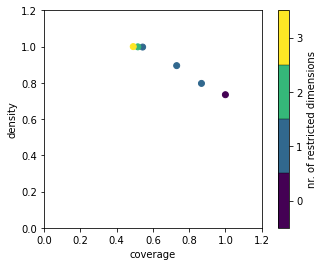

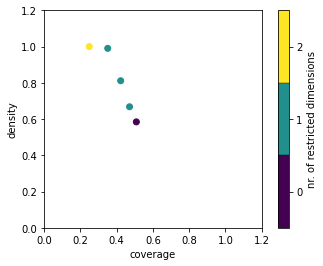

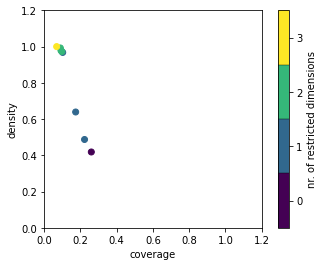

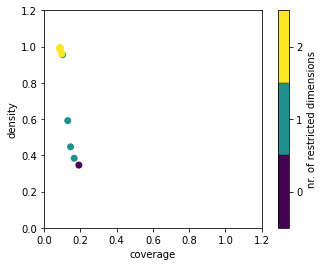

In [35]:
for b in boxes:
    b.show_tradeoff()
    plt.show()

coverage    0.491491
density     1.000000
id          5.000000
mass        0.361000
mean        1.000000
res_dim     3.000000
Name: 5, dtype: float64

                       box 5                                          
                         min        max                      qp values
spawnFrequencyD     1.000000   2.500000  [-1.0, 5.740681565146647e-97]
pedPotentialHeight  5.021724  47.636220     [-1.0, 0.3864991737286148]
meanFreeFlowSpeed   0.684807   1.159758    [0.38601507886915515, -1.0]



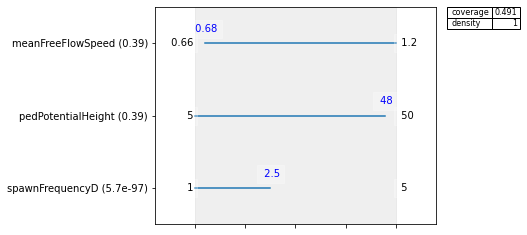

coverage    0.248468
density     1.000000
id          4.000000
mass        0.182500
mean        1.000000
res_dim     2.000000
Name: 4, dtype: float64

                box 4                                    
                  min  max                      qp values
spawnFrequencyC   1.0  2.5  [-1.0, 5.238110074104261e-74]
spawnFrequencyD   1.0  4.5   [-1.0, 0.029404796173664035]



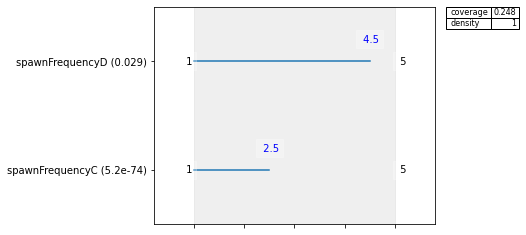

coverage    0.068754
density     1.000000
id          7.000000
mass        0.050500
mean        1.000000
res_dim     3.000000
Name: 7, dtype: float64

                        box 7                                          
                          min       max                       qp values
spawnFrequencyC      1.000000  2.500000  [-1.0, 4.1333050853999966e-38]
obstPotentialHeight  2.003379  8.782347     [-1.0, 0.07752935761528565]
spawnFrequencyB      1.500000  5.000000     [0.46391008033980957, -1.0]



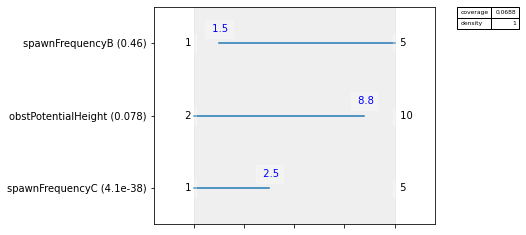

coverage     0.089176
density      0.992424
id          11.000000
mass         0.066000
mean         0.992424
res_dim      2.000000
Name: 11, dtype: float64

                     box 11                                         
                        min       max                      qp values
spawnFrequencyA    1.000000  1.500000  [-1.0, 4.277496052625611e-62]
meanFreeFlowSpeed  0.710602  1.159758   [0.016809465385086597, -1.0]



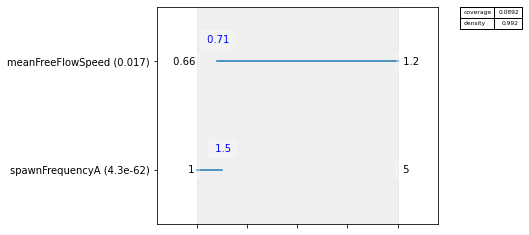

In [36]:
for b in boxes:
    b.inspect()
    b.inspect(style="graph")
    plt.show()